# Churn Prediction - Modeling
---
**Table of Contents** :

0. Importance of Churn Prediction
1. Import packages and Define functions
2. Load data
3. Modeling
4. Assess the effectiveness of Feature Engineering
5. Model Understanding
6. Simplify the Model
7. Handle imbalanced data
8. Retention Strategy and Recommended Resampling Methods


---
## 0. Importance of Churn Prediction
Churn prediction enables us to identify customers likely to leave, allowing for targeted retention efforts that can enhance the ROI of marketing strategies. For Power Co, I propose a retention strategy focused on offering a 20% discount to high-value customers—those with a net margin at or above the third quartile (Q3) and who are predicted to be at risk of churning. Since resources are limited, prioritizing high-value customers ensures that retention efforts are directed where they can have the greatest impact.

---
## 1. Import packages and Define functions

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)
plt.style.use('ggplot')

In [3]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(dataframe.columns, loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, bins_, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """
    #print(len(ax.patches))
    # Iterate over the plotted rectanges/bars
    for i in range(len(ax.patches)):
        

        if (i<bins_) :
        # Calculate annotation
            bar_total_height = (ax.patches[i].get_height() + ax.patches[i+int(bins_)].get_height())
        else :
            bar_total_height = (ax.patches[i].get_height() + ax.patches[i-int(bins_)].get_height())

        
        value = (ax.patches[i].get_height()/ bar_total_height) * 100

        if (np.isnan(value) or value < 5 or (bar_total_height < 50)):
            continue
            
        value = str(round(value,1)) + '%'
        #print(value)
        
        ax.annotate(
            value,
            #((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            ((ax.patches[i].get_x()), (ax.patches[i].get_y()+ax.patches[i].get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})

    #print(temp)
    # Plot the histogram
    temp[["Retention", "Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')
    annotate_stacked_bars(ax, bins_ = bins_, textsize=14)


---
## 2. Load data

In [4]:
df = pd.read_csv('./data/data_for_modeling.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_pow_off_peak,imp_cons,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,40.606701,0.00000,...,2,6,False,False,True,False,False,False,False,True
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,44.311378,0.00000,...,76,4,True,False,False,False,False,True,False,False
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,44.311378,0.00000,...,68,8,False,False,True,False,False,True,False,False
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,44.311378,0.00000,...,69,9,False,False,False,True,False,True,False,False
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,40.606701,1.72689,...,71,9,True,False,False,False,False,True,False,False


In [5]:
df.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_pow_off_peak', 'imp_cons', 'margin_net_pow_ele',
       'nb_prod_act', 'net_margin', 'pow_max', 'churn',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'peak_diff_dec_january_energy', 'midpeak_diff_dec_january_power',
       'peak_off_peak_var_mean_diff', 'mid_peak_peak_var_mean_diff',
       'peak_off_peak_var_max_monthly_diff',
       'mid_peak_peak_var_max_monthly_diff',
       'mid_peak_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff', 'tenure', 'months_to_end',
       'months_modif_prod', 'months_renewal', 'channel_MISSING',
       'channel_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_lmkebamcaaclubfxadlmueccxoimlema',
       'channel_usilxuppasemubllopkaafesm

---

## 3. Modeling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [6]:
# Make a copy of our data
train_df = df.copy()
train_df = train_df.dropna()
train_df = train_df.set_index(['id'])
# Separate target variable from independent variables
y = train_df['churn']
#X = train_df.set_index(['id'])
X = train_df.drop(columns=['churn'])
#X = train_df.drop(columns=['churn'])
print(X.shape)
print(y.shape)

(14535, 35)
(14535,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10901, 35)
(10901,)
(3634, 35)
(3634,)


In [8]:
y_test.value_counts()

churn
0    3291
1     343
Name: count, dtype: int64

the targeted variable is very imbalanced

#### Model training

We are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm. 

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging. 

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [9]:
# Add model training in here!
model = RandomForestClassifier(n_estimators=100,class_weight='balanced') # Add parameters to the model!
model.fit(X = X_train, y = y_train) # Complete this method call!

RandomForestClassifier(class_weight='balanced')

The `scikit-learn` documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html>, has a lot of information about the algorithm and the parameters that you can use when training a model.

For this example, I am using `n_estimators` = 100. This means that my random forest will consist of 100 decision trees. There are many more parameters that you can fine-tune within the random forest and finding the optimal combinations of parameters can be a manual task of exploration, trial and error, which will not be covered during this notebook.

#### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples

The reason why we are using these three metrics is because a simple accuracy is not always a good measure to use. To give an example, let's say you're predicting heart failures with patients in a hospital and there were 100 patients out of 1000 that did have a heart failure. 

If you predicted 80 out of 100 (80%) of the patients that did have a heart failure correctly, you might think that you've done well! However, this also means that you predicted 20 wrong and what may the implications of predicting these remaining 20 patients wrong? Maybe they miss out on getting vital treatment to save their lives. 

As well as this, what about the impact of predicting negative cases as positive (people not having heart failure being predicted that they did), maybe a high number of false positives means that resources get used up on thee wrong people and a lot of time is wasted when they could have been helping the real heart failure sufferers. 

This is just an example, but it illustrates why other performance metrics are necessary such `Precision` and `Recall`, which are good measures to use in a classification scenario.

In [10]:
y_pred = model.predict(X = X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
# Generate predictions here!

In [11]:
confusion_matrix(y_test, y_pred)

array([[3290,    1],
       [ 320,   23]])

In [12]:
y_test.value_counts()

churn
0    3291
1     343
Name: count, dtype: int64

In [13]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision: {metrics.precision_score(y_test, y_pred)}")
print(f"Recall: {metrics.recall_score(y_test, y_pred)}")

True positives: 23
False positives: 1
True negatives: 3290
False negatives: 320

Accuracy: 0.9116675839295542
Precision: 0.9583333333333334
Recall: 0.06705539358600583


Looking at these results there are a few things to point out:

<b>Note:</b> If you are running this notebook yourself, you may get slightly different answers!

- Within the test set about 10% of the rows are churners (churn = 1).
- Looking at the true negatives, we have 3282 out of 3286. This means that out of all the negative cases (churn = 0), we predicted 3282 as negative (hence the name True negative). This is great!
- Looking at the false negatives, this is where we have predicted a client to not churn (churn = 0) when in fact they did churn (churn = 1). This number is quite high at 348, we want to get the false negatives to as close to 0 as we can, so this would need to be addressed when improving the model.
- Looking at false positives, this is where we have predicted a client to churn when they actually didnt churn. For this value we can see there are 4 cases, which is great!
- With the true positives, we can see that in total we have 366 clients that churned in the test dataset. However, we are only able to correctly identify 18 of those 366, which is very poor.
- Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.
- Looking at the precision score, this shows us a score of 0.82 which is not bad, but could be improved.
- However, the recall shows us that the classifier has a very poor ability to identify positive samples. This would be the main concern for improving this model!

So overall, we're able to very accurately identify clients that do not churn, but we are not able to predict cases where clients do churn! What we are seeing is that a high % of clients are being identified as not churning when they should be identified as churning. This in turn tells me that the current set of features are not discriminative enough to clearly distinguish between churners and non-churners. 

For now, let's evaluate the effectiveness of feature engineering. 


---
## 4. Effectiveness of Feature Engineering
To evaluate effectiveness of feature engineering, we should build and compare two models: one that excludes variables created through feature engineering and one that includes them.

In [14]:
X_train.columns

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_pow_off_peak',
       'imp_cons', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin',
       'pow_max', 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'midpeak_diff_dec_january_power', 'peak_off_peak_var_mean_diff',
       'mid_peak_peak_var_mean_diff', 'peak_off_peak_var_max_monthly_diff',
       'mid_peak_peak_var_max_monthly_diff',
       'mid_peak_peak_fix_max_monthly_diff',
       'off_peak_mid_peak_fix_max_monthly_diff', 'tenure', 'months_to_end',
       'months_modif_prod', 'months_renewal', 'channel_MISSING',
       'channel_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_lmkebamcaaclubfxadlmueccxoimlema',
       'channel_usilxuppasemubllopkaafesmlibmsdf',
       'orig

In [15]:
columns_without_feature_engineering = []
for col in X_train.columns : 
    if ('diff' not in col) :
        columns_without_feature_engineering.append(col)

columns_used = [columns_without_feature_engineering,X_train.columns]

situation = ['No Feature Engineering', 'With Feature Engineering']
accuracy = []
precision = []
recall = []
for col in columns_used : 
    model = RandomForestClassifier(n_estimators=100,class_weight='balanced') # Add parameters to the model!
    model.fit(X = X_train[col], y = y_train) # Complete this method call!
    y_pred = model.predict(X = X_test[col])
    #tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()  
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    precision.append(metrics.precision_score(y_test, y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))


dict = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall
}


result = pd.DataFrame.from_dict(dict, orient='index', columns = situation)

result

,No Feature Engineering,With Feature Engineering
accuracy,0.911392,0.911117
precision,0.920000,0.916667
recall,0.067055,0.064140


it seems like feature engineering does not helpful in predicting churn
Let’s explore this further!

---
## 5.  Model understanding

A simple way of understanding the results of a model is to look at feature importances. Feature importances indicate the importance of a feature within the predictive model, there are several ways to calculate feature importance, but with the Random Forest classifier, we're able to extract feature importances using the built-in method on the trained model. In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees.

In [16]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


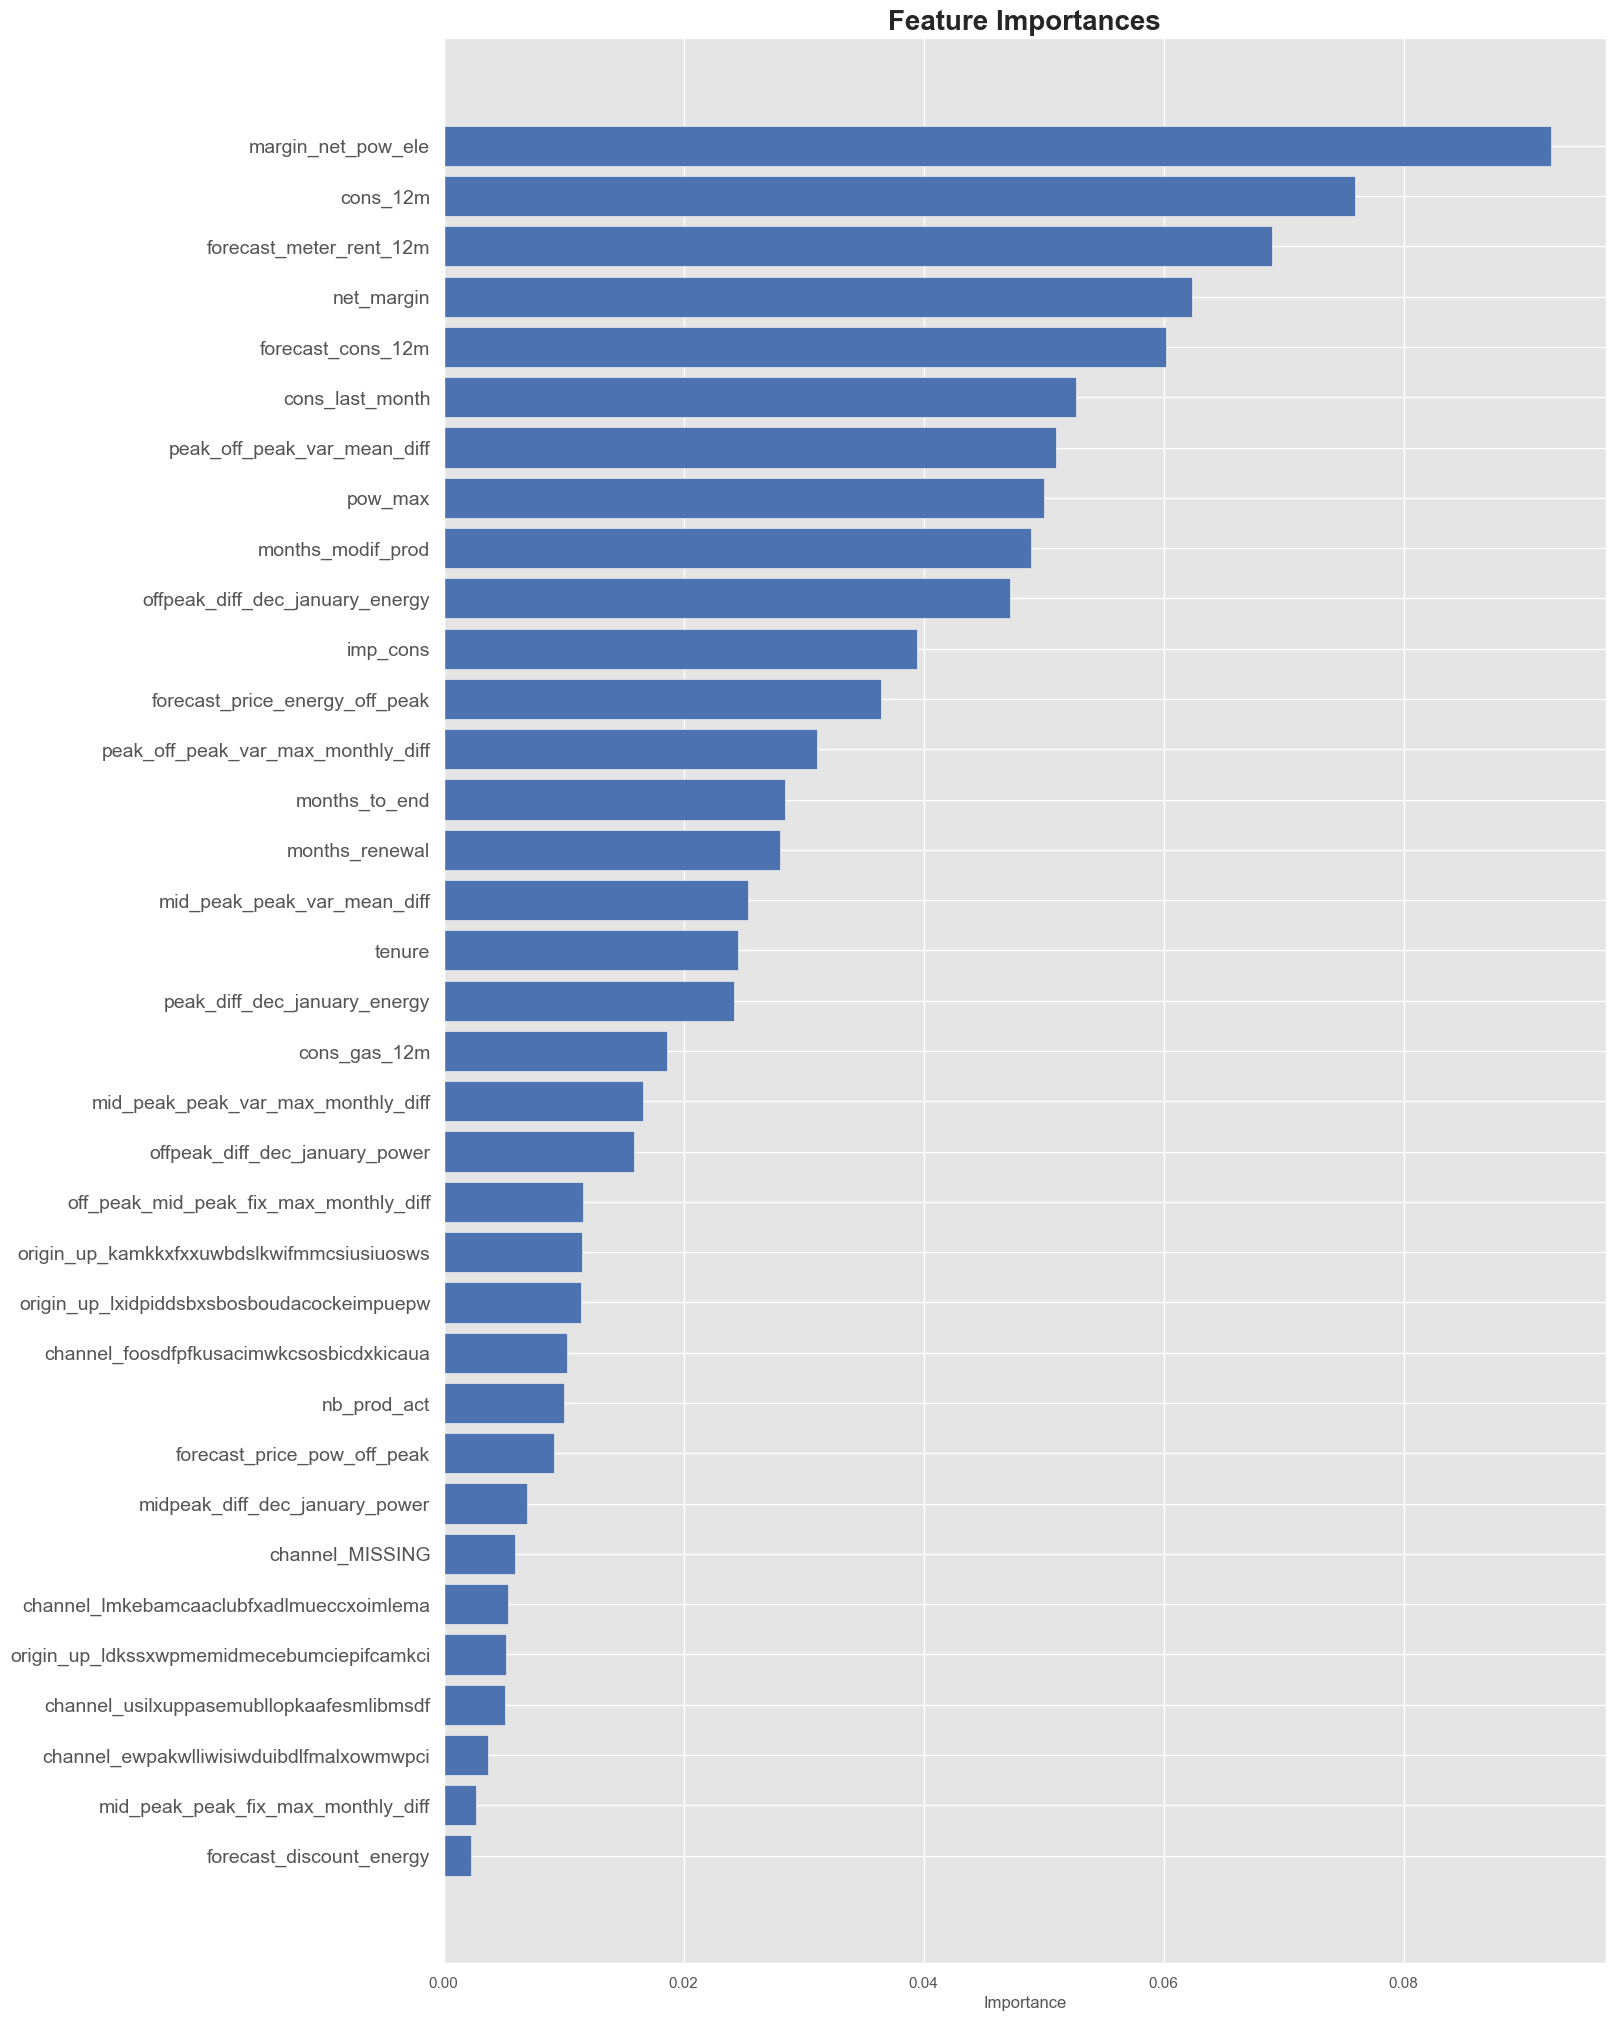

In [17]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances', fontsize = 20, weight = 'bold')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'],fontsize=14)
plt.xlabel('Importance')
plt.show()

From this chart, we can observe the following points:

- Net margin and consumption over 12 months is a top driver for churn in this model
- Time seems to be an influential factor, especially the number of months since they updated their contract
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

The second-to-last observation is important because this relates back to our original hypothesis:

    > Is churn driven by the customers' price sensitivity?

Based on the output of the feature importances, it is not a main driver but it is a weak contributor.


We can further illustrate this finding through visualizations.

### Data Visualization : Association between  price sensitivity features and Churn

#### Annual Price Variation

/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100
/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100
/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100


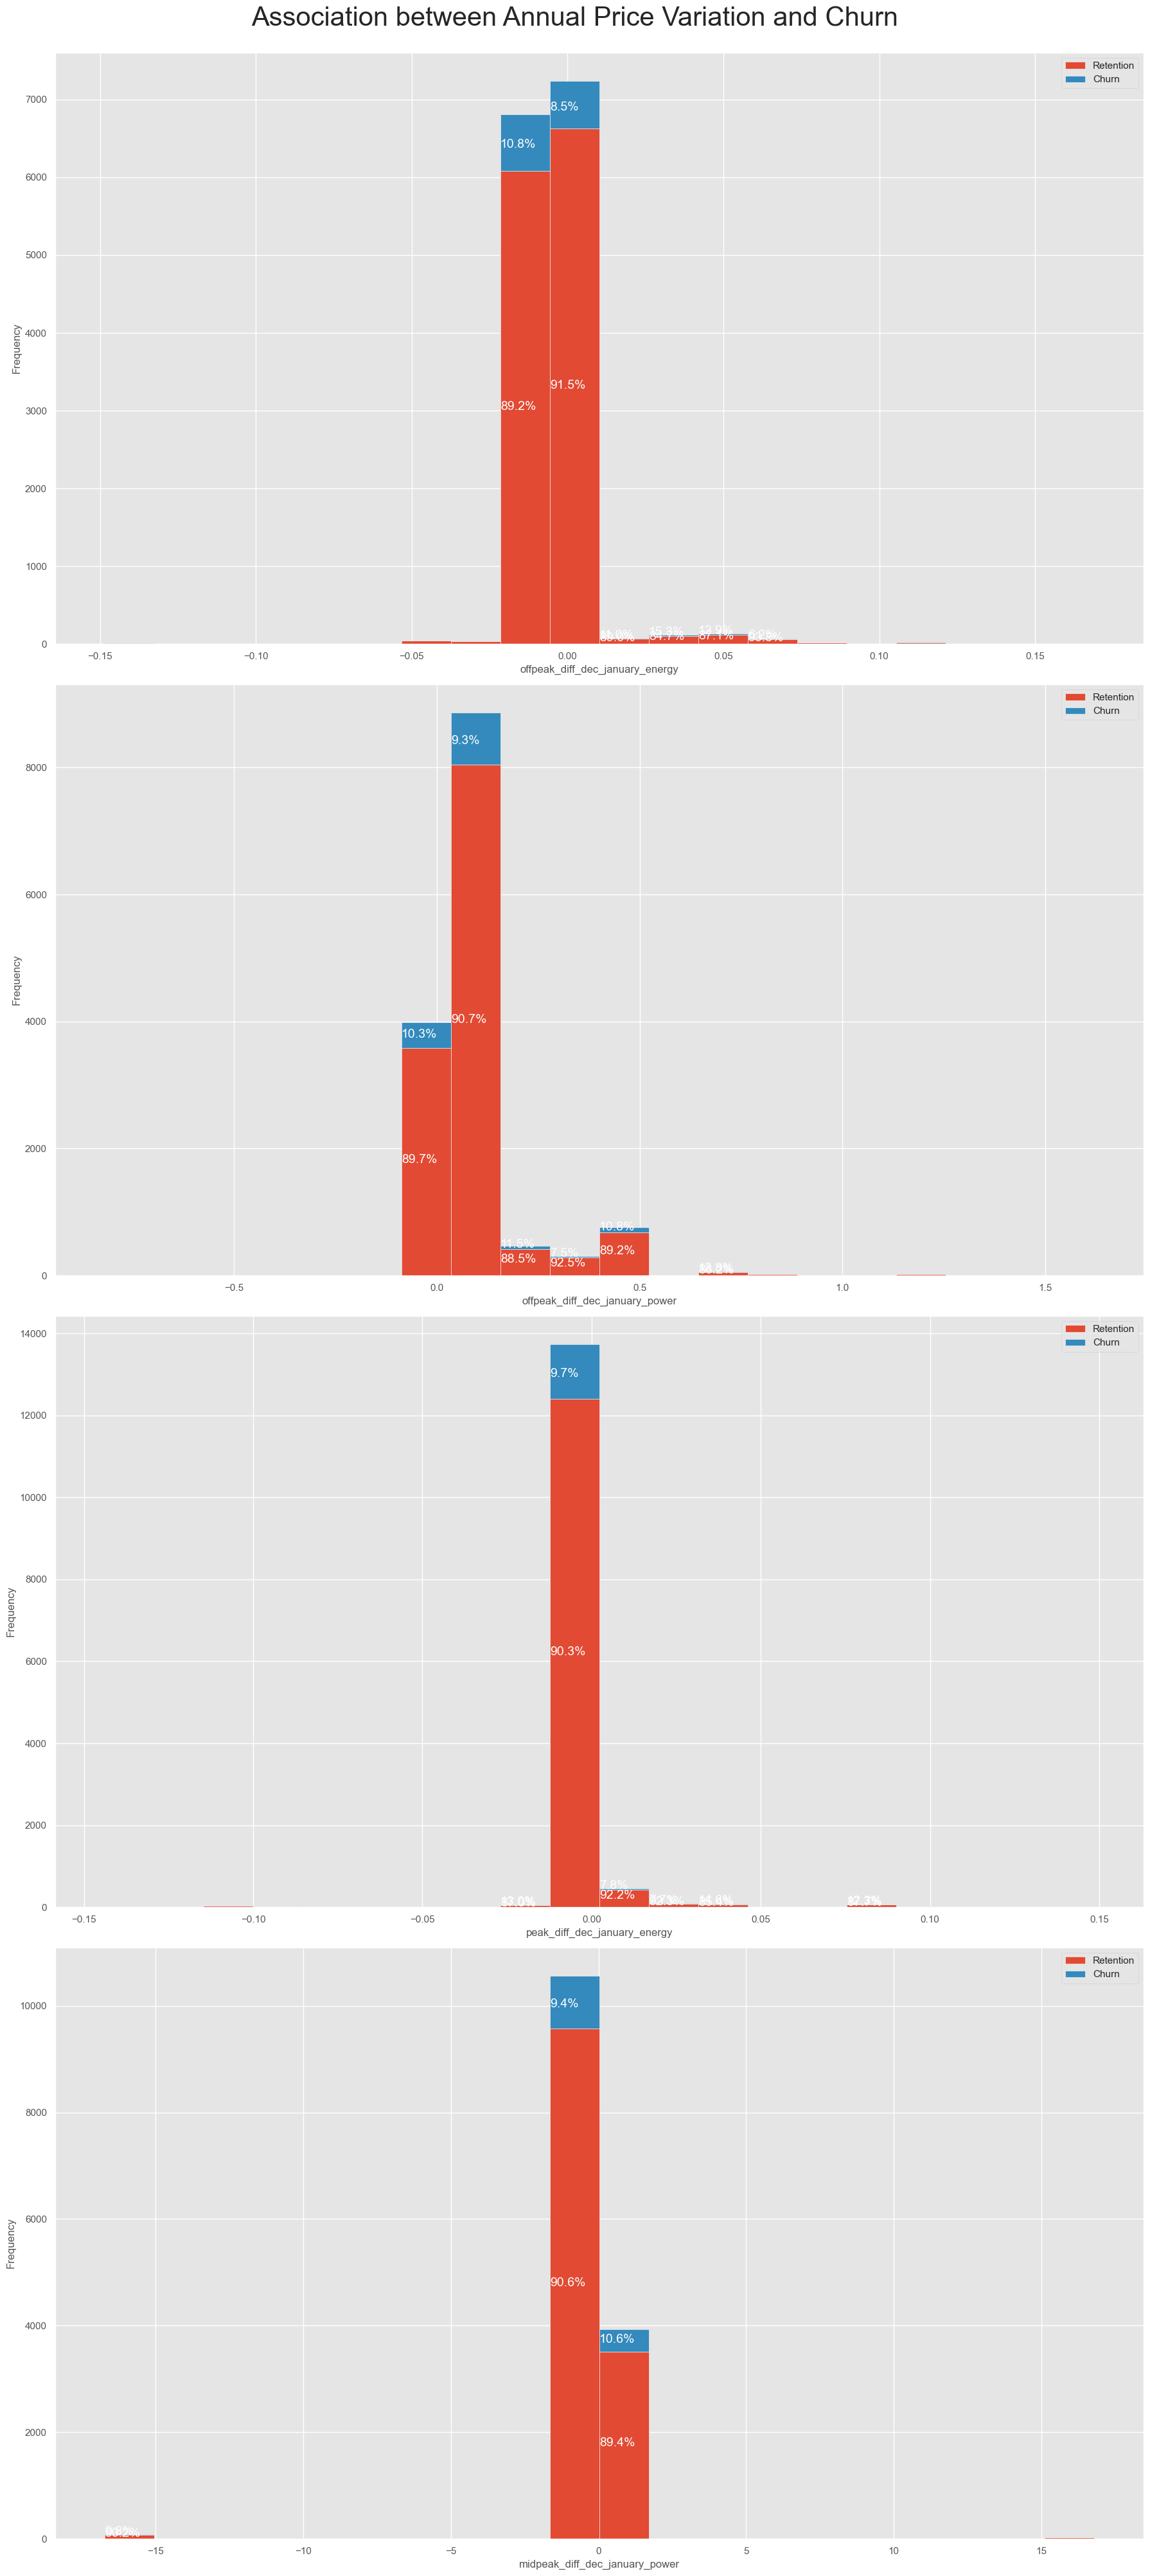

In [18]:
columns = ['offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power','peak_diff_dec_january_energy','midpeak_diff_dec_january_power']
fig, axs = plt.subplots(nrows=len(columns),ncols=1, figsize=(18,10 * len(columns)))

axs = axs.flatten()

for ax,col in zip(axs,columns) :
    #print(df[col].dtype)
    plot_distribution(df, col, ax, bins_=20)

plt.suptitle('Association between Annual Price Variation and Churn',fontsize=30,y=1.001)
plt.subplots_adjust(hspace=0.2,wspace=0)
plt.tight_layout()

plt.show()



#### Period-to-Period Rate Differentials

/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100


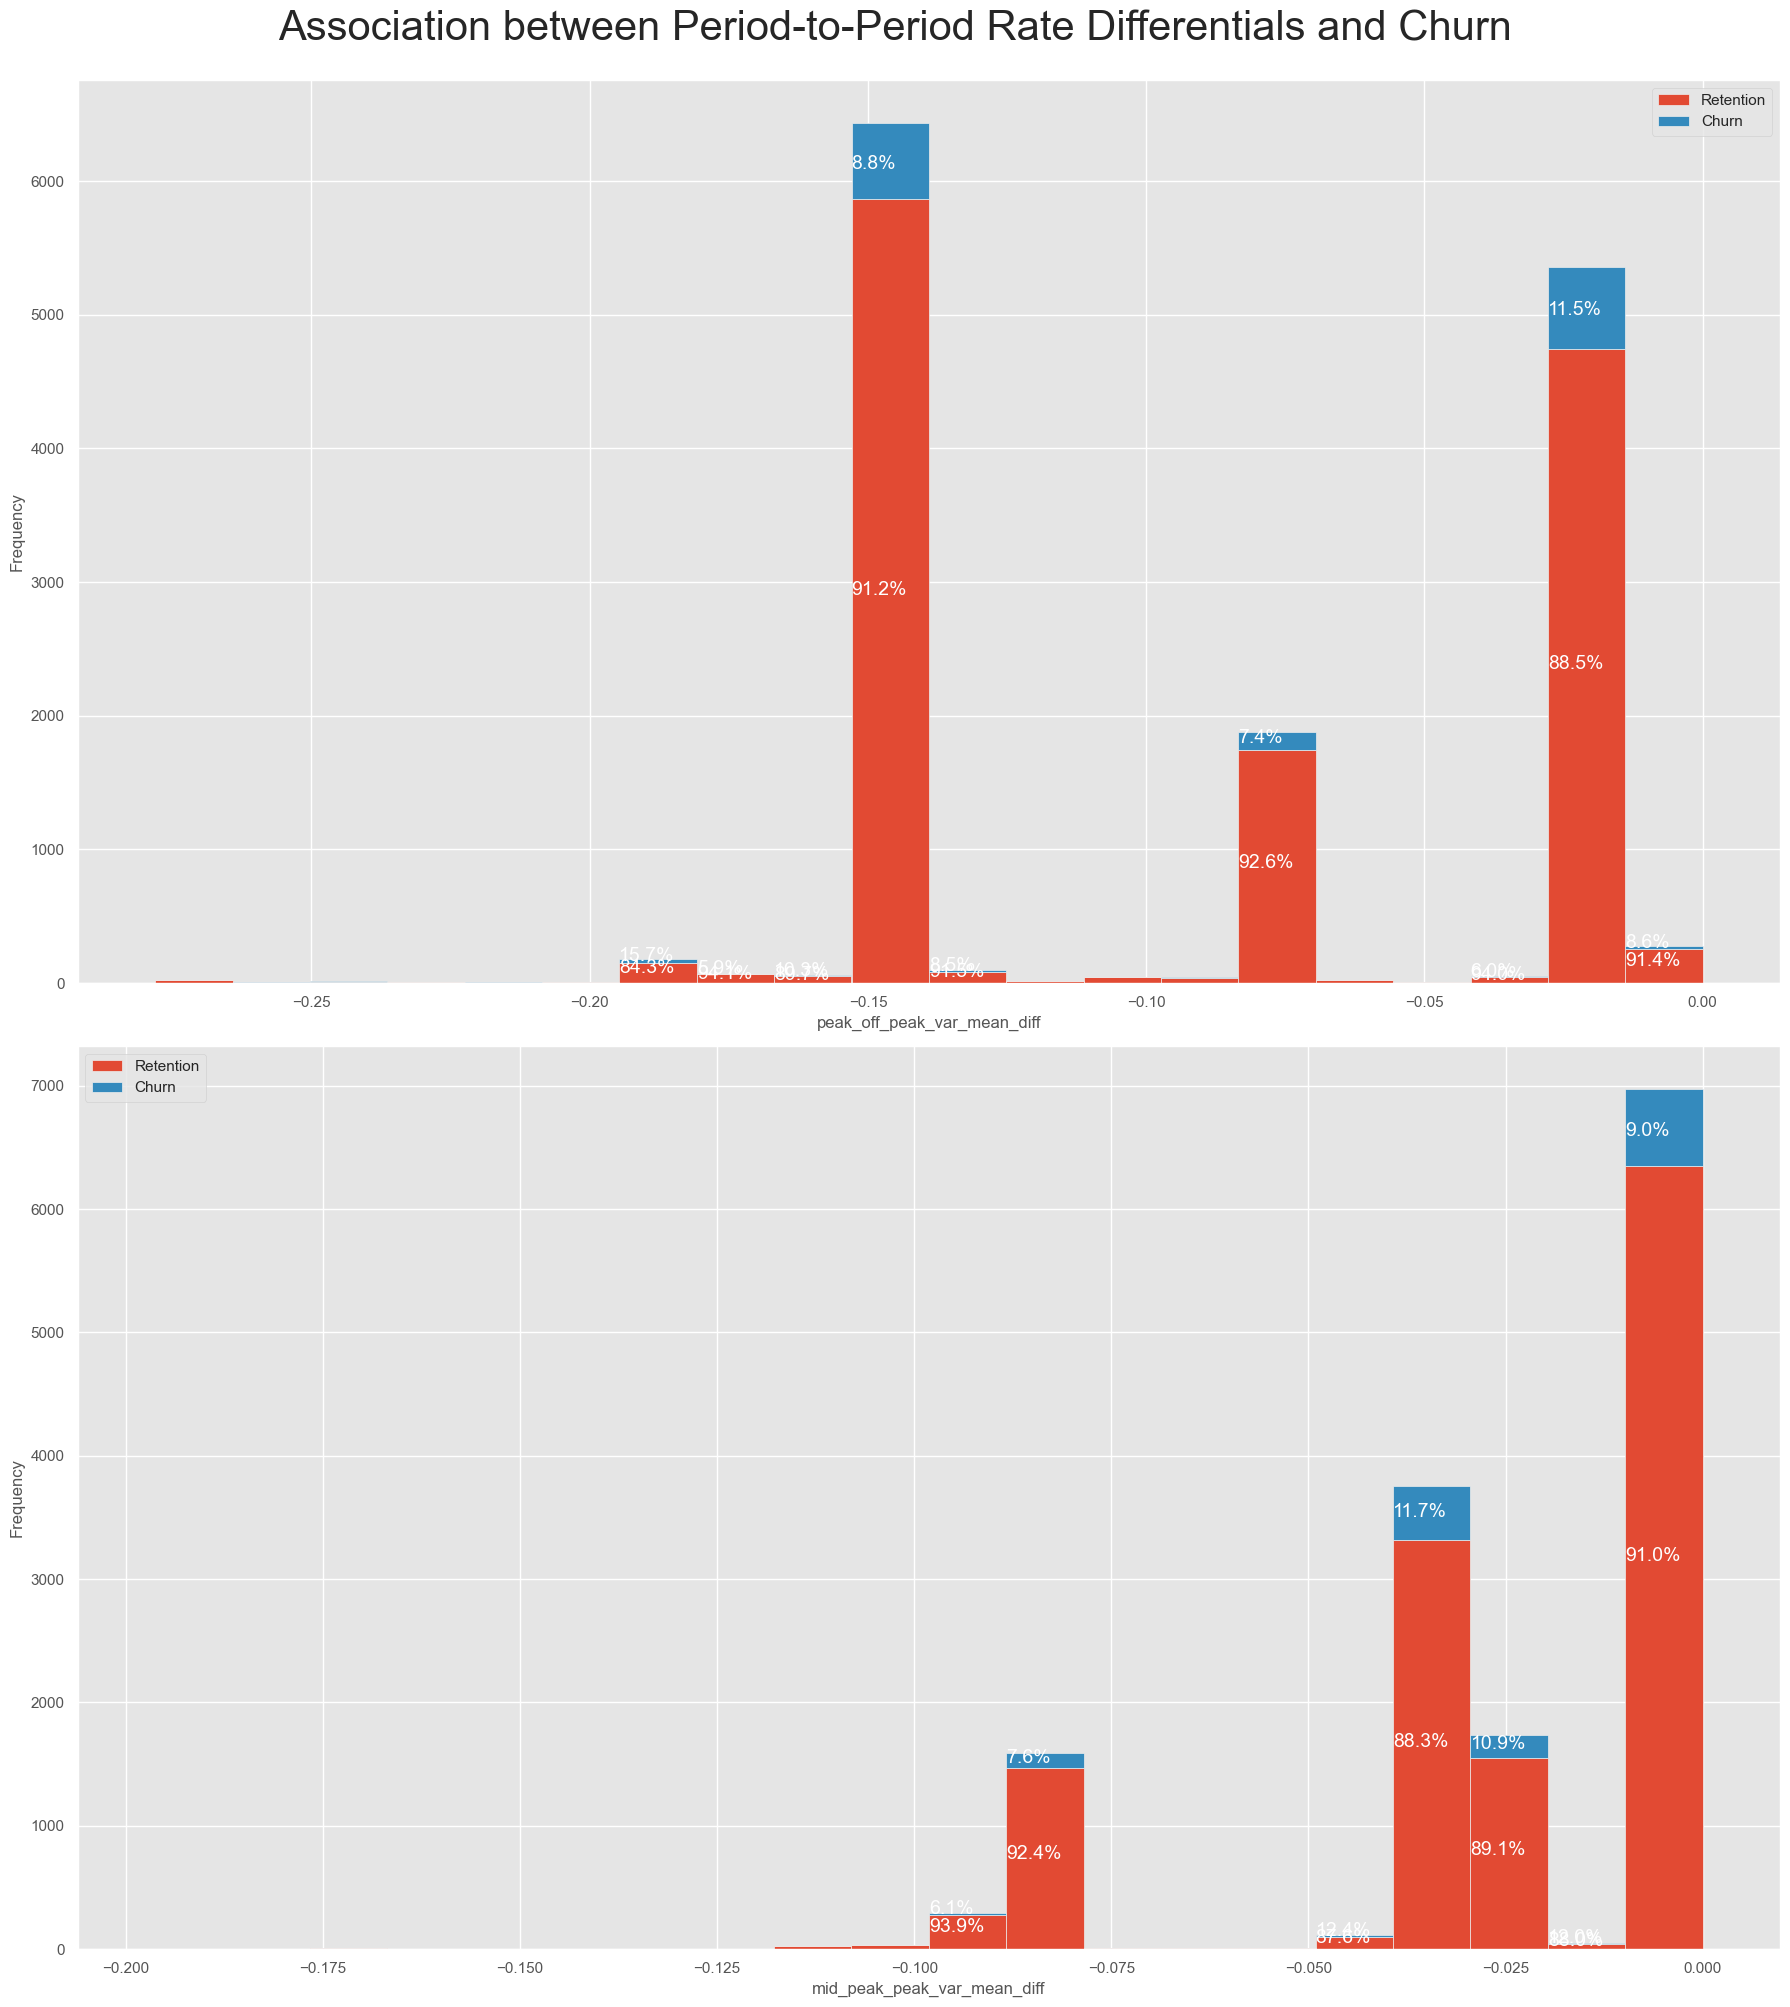

In [19]:
columns = [ 
    'peak_off_peak_var_mean_diff',
    'mid_peak_peak_var_mean_diff'
]

fig, axs = plt.subplots(nrows=len(columns),ncols=1, figsize=(18,10 * len(columns)))

axs = axs.flatten()

for ax,col in zip(axs,columns) :
    #print(df[col].dtype)
    plot_distribution(df, col, ax, bins_=20)

plt.suptitle('Association between Period-to-Period Rate Differentials and Churn',fontsize=30,y=1.001)
plt.subplots_adjust(hspace=0.2,wspace=0)
plt.tight_layout()

plt.show()



#### Maximum of Monthly Period-to-Period Rate Differentials

/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100
/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100
/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100
/var/folders/lt/0c8vrg812nl928pftmdzt1xw0000gn/T/ipykernel_85594/1377435571.py:37: RuntimeWarning: invalid value encountered in scalar divide
  value = (ax.patches[i].get_height()/ bar_total_height) * 100


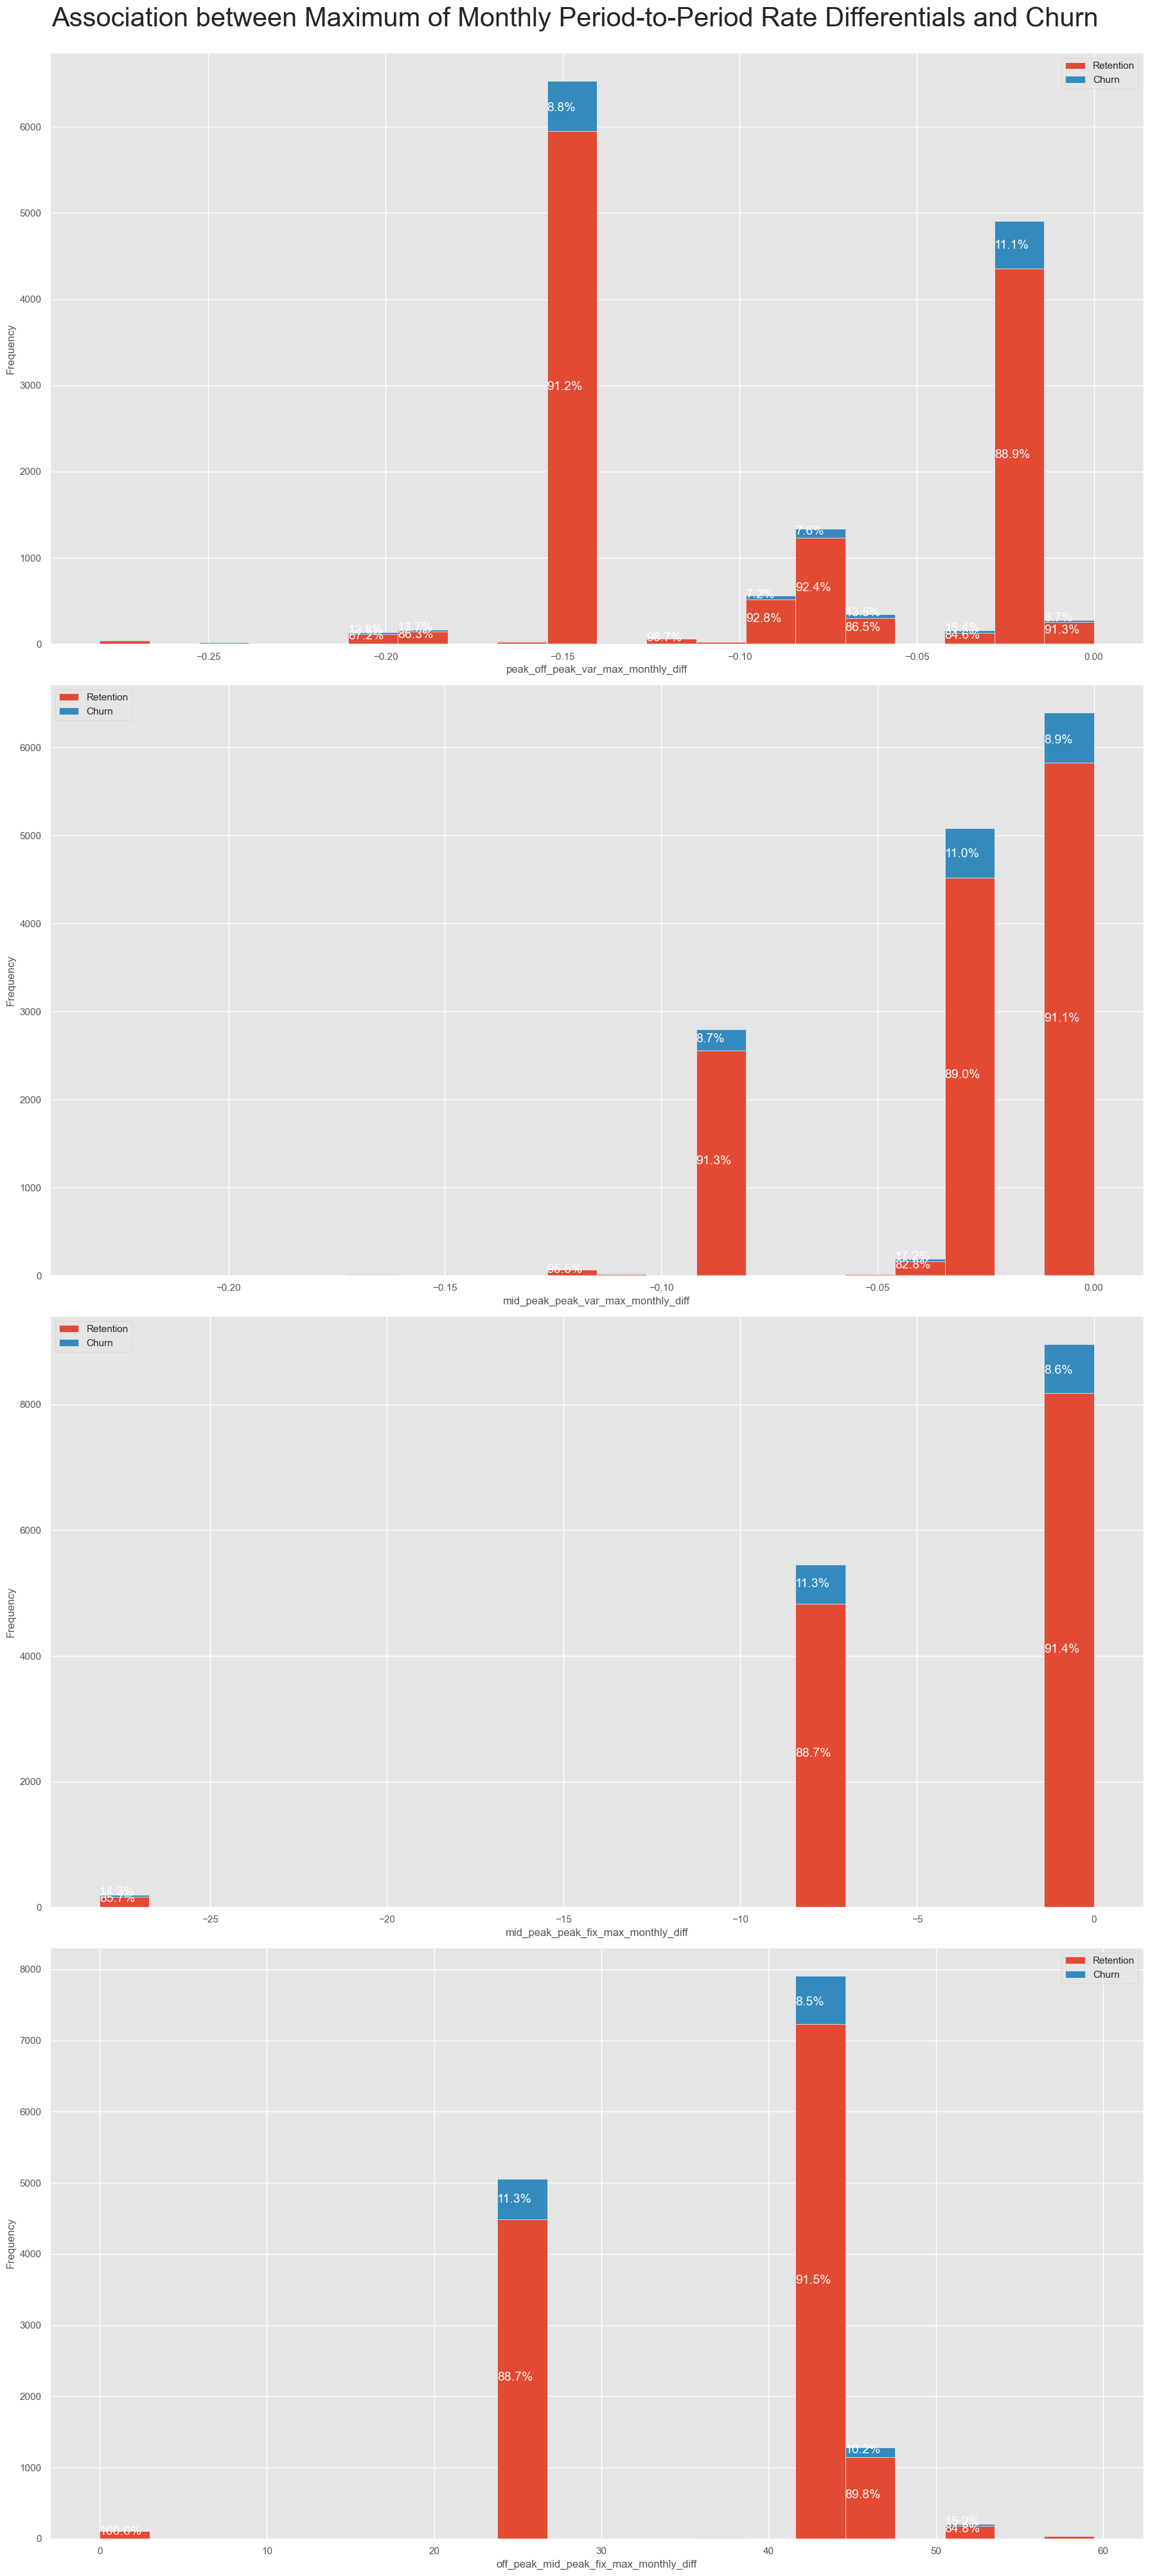

In [20]:
columns = [
    'peak_off_peak_var_max_monthly_diff',
    'mid_peak_peak_var_max_monthly_diff',
    'mid_peak_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]


fig, axs = plt.subplots(nrows=len(columns),ncols=1, figsize=(18,10 * len(columns)))

axs = axs.flatten()

for ax,col in zip(axs,columns) :
    #print(df[col].dtype)
    plot_distribution(df, col, ax, bins_=20)

plt.suptitle('Association between Maximum of Monthly Period-to-Period Rate Differentials and Churn',fontsize=30,y=1.001)
plt.subplots_adjust(hspace=0.2,wspace=0)
plt.tight_layout()

plt.show()


**No obvious pattern observed from the visualization above** 

---
## 6. Simplify the model
The feature importance plot shows that some features are relatively unimportant for predicting churn. To simplify the model, we can focus on the top N most important variables.

This approach not only streamlines the model but also helps prevent overfitting by reducing the number of less relevant features.

In [21]:
most_important_10_features = feature_importances.sort_values(by='importance', ascending=False).iloc[:10]['features'].to_list()
most_important_20_features = feature_importances.sort_values(by='importance', ascending=False).iloc[:20]['features'].to_list()

# columns_without_feature_engineering = []
# for col in X_train.columns : 
#     if ('diff' not in col) :
#         columns_without_feature_engineering.append(col)

columns_used = [columns_without_feature_engineering,X_train.columns,most_important_10_features,most_important_20_features]

situation = ['No Feature Engineering', 'With Feature Engineering', '10 Most Important Variables','20 Most Important Variables']
accuracy = []
precision = []
recall = []
for col in columns_used : 
    model = RandomForestClassifier(n_estimators=100,class_weight='balanced') # Add parameters to the model!
    model.fit(X = X_train[col], y = y_train) # Complete this method call!
    y_pred = model.predict(X = X_test[col])
    #tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()  
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    precision.append(metrics.precision_score(y_test, y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))


dict = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall
}


result = pd.DataFrame.from_dict(dict, orient='index', columns = situation)

result

,No Feature Engineering,With Feature Engineering,10 Most Important Variables,20 Most Important Variables
accuracy,0.910842,0.910842,0.909191,0.911392
precision,1.000000,1.000000,0.809524,0.920000
recall,0.055394,0.055394,0.049563,0.067055


The results suggest that using the top 20 most important variables to build the new model still yields high accuracy, precision, and recall, compared to the full model (with feature engineering).

---
## 7. Handle imbalanced data
- One reason for the low recall is that the churn class (1) makes up only about 10% of the data. As a result, it is challenging for the model to predict churn accurately, since the pattern for this minority class is harder to capture. Additionally, with a large number of negative cases, the model may overfit to this majority class and become biased toward predicting 'negative.'
- To address this imbalance, we can use techniques such as oversampling, undersampling, or SMOTE to help the model better capture the minority class.


**Methods**:
- Oversampling: Increase the number of samples in the minority class by duplicating existing samples or generating new ones synthetically.
    - SMOTE (Synthetic Minority Over-sampling Technique): This technique generates synthetic samples by interpolating between existing minority class samples.
    - Random Oversampling: Duplicate random samples from the minority class until the classes are balanced.
- Undersampling: Reduce the number of samples in the majority class.
    - Random Undersampling: Randomly remove samples from the majority class until the classes are balanced.
    - Cluster Centroids: Reduce the majority class samples by clustering and using cluster centroids as representatives of the majority class.
- Mix of Oversampling and Undersampling :
    - Oversampling: The SMOTE (Synthetic Minority Over-sampling Technique) component generates synthetic samples for the minority class to increase its representation.
    - Undersampling: The ENN (Edited Nearest Neighbors) component performs undersampling by removing potentially noisy or ambiguous samples from the majority class based on nearest neighbors.


#### Random Oversampling

In [22]:

# Assuming X and y are your feature matrix and target vector
# Combine X and y into a single DataFrame
data = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority class
minority_class = data[data[y.name] == 1]
majority_class = data[data[y.name] == 0]

# Randomly upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,        # Sample with replacement
                              n_samples=len(majority_class),  # Match the majority class size
                              random_state=42)

# Combine back the majority class and upsampled minority class
data_upsampled = pd.concat([majority_class, minority_upsampled])

# Separate features and target
X_upsampled = data_upsampled.drop(columns=[y.name])
y_upsampled = data_upsampled[y.name]


#### SMOTE Oversampling

In [23]:
# Apply SMOTE to generate synthetic data points for the minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

#### Random Undersampling

In [24]:
# Randomly undersample the majority class
majority_undersampled = resample(majority_class,
                                 replace=False,       # Sample without replacement
                                 n_samples=len(minority_class),  # Match the minority class size
                                 random_state=42)

# Combine the minority class with the undersampled majority class
data_undersampled = pd.concat([minority_class, majority_undersampled])

# Separate features and target
X_undersampled = data_undersampled.drop(columns=[y.name])
y_undersampled = data_undersampled[y.name]


#### Undersampling with Clustering

In [25]:
# Apply ClusterCentroids to under-sample the majority class using clustering
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_train, y_train)


#### SMOTE ENN 

In [26]:
# Initialize SMOTE with a random state for reproducibility
smote_enn = SMOTEENN(random_state=42)

# Fit and resample the training data
X_smote_enn, y_smote_enn = smote_enn.fit_resample(X_train, y_train)

#### Compare effectiveness of different resampling methods

In [27]:
def evaluate_retention_strategy(y_pred, X_train = X_train,  X_test = X_test, y_test = y_test) :
    temp = X_test.copy(deep=True)
    temp['y_pred'] = y_pred
    temp['churn'] = y_test

    net_magin_q3 = X_train['net_margin'].describe()['75%']
    high_value_customers = temp[ temp['net_margin'] >= net_magin_q3].index.to_list()
    targeted_customers_retention_campaign = temp[ (temp['net_margin'] >= net_magin_q3) & temp['y_pred'] == 1].index.to_list()
    churn_high_value_customers = temp[ (temp['net_margin'] >= net_magin_q3) & (temp['churn'] == 1)].index.to_list()
    #print(targeted_customers_retention_campaign)
    #print(churn_high_value_customers)
    
    intersection = list(set(targeted_customers_retention_campaign) & set(churn_high_value_customers))

    precision_mkt_strategy = len(intersection)/len(targeted_customers_retention_campaign)
    recall_mkt_strategy = len(intersection)/len(churn_high_value_customers)
    f1_score_mkt_strategy = 2 * precision_mkt_strategy * recall_mkt_strategy/ (precision_mkt_strategy+recall_mkt_strategy)
    budget_saving = str(round((1 - (len(targeted_customers_retention_campaign)/len(high_value_customers))) * 100,2) ) + '%'


    return [precision_mkt_strategy, recall_mkt_strategy,f1_score_mkt_strategy,budget_saving]

In [28]:
X_train_new = [X_train,X_upsampled,X_smote,X_undersampled,X_cc,X_smote_enn]
y_train_new = [y_train,y_upsampled,y_smote,y_undersampled,y_cc,y_smote_enn]


situation = ['20 Most Important Variables(Baseline)','Random Oversampling','SMOTE Oversampling','Random Undersampling','Undersampling with Clustering','SMOTE ENN']
accuracy = []
precision = []
recall = []
f1_score = []
precision_mkt_strategy = []
recall_mkt_strategy = []
f1_score_mkt_strategy = []
budget_saving_mkt_strategy = []


for X_temp, y_temp,s in zip(X_train_new,y_train_new,situation) :
    X_new_train = X_temp[most_important_20_features]
    X_new_test = X_test[most_important_20_features]
    #X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
    model = RandomForestClassifier(n_estimators=100,class_weight='balanced')
    model.fit(X_new_train, y_temp)
    y_pred = model.predict(X = X_new_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    precision.append(metrics.precision_score(y_test, y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))
    f1_score.append(metrics.f1_score(y_test, y_pred))

    mkt_strategy_metric = evaluate_retention_strategy(y_pred = y_pred)
    precision_mkt_strategy.append(mkt_strategy_metric[0])
    recall_mkt_strategy.append(mkt_strategy_metric[1])
    f1_score_mkt_strategy.append(mkt_strategy_metric[2])
    budget_saving_mkt_strategy.append(mkt_strategy_metric[3])
    
    print(f'Confusion Matrix of {s}')
    print(confusion_matrix(y_test, y_pred))

dict = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall,
    'f1_score' : f1_score,
    'precision_high_value_customers' : precision_mkt_strategy,
    'recall_high_value_customers' : recall_mkt_strategy,
    'f1_score_high_value_customers' : f1_score_mkt_strategy,
    #'budget saving' : budget_saving_mkt_strategy
}


result = pd.DataFrame.from_dict(dict, orient='index', columns = situation)

temp = X_test.copy(deep=True)
temp['y_pred'] = y_pred
temp['churn'] = y_test
net_magin_q3 = X_train['net_margin'].describe()['75%']

precision_high_value_customers_without_churn_prediction = len(temp[ (temp['net_margin']>= net_magin_q3) & (temp['churn'] == 1 ) ] ) / len(temp[ temp['net_margin']>= net_magin_q3])

Confusion Matrix of 20 Most Important Variables(Baseline)
[[3288    3]
 [ 322   21]]
Confusion Matrix of Random Oversampling
[[3270   21]
 [ 310   33]]
Confusion Matrix of SMOTE Oversampling
[[3223   68]
 [ 297   46]]
Confusion Matrix of Random Undersampling
[[2124 1167]
 [ 138  205]]
Confusion Matrix of Undersampling with Clustering
[[ 255 3036]
 [  23  320]]
Confusion Matrix of SMOTE ENN
[[2967  324]
 [ 237  106]]


In [29]:
result

,20 Most Important Variables(Baseline),Random Oversampling,SMOTE Oversampling,Random Undersampling,Undersampling with Clustering,SMOTE ENN
accuracy,0.910567,0.908916,0.899560,0.640892,0.158228,0.845625
precision,0.875000,0.611111,0.403509,0.149417,0.095352,0.246512
recall,0.061224,0.096210,0.134111,0.597668,0.932945,0.309038
f1_score,0.114441,0.166247,0.201313,0.239067,0.173020,0.274256
precision_high_value_customers,0.400000,0.416667,0.242424,0.153425,0.102672,0.228346
recall_high_value_customers,0.022472,0.056180,0.089888,0.629213,0.820225,0.325843
f1_score_high_value_customers,0.042553,0.099010,0.131148,0.246696,0.182500,0.268519


Based on the results, we observe a significant improvement in recall across all resampling methods. However, precision decreases notably, highlighting the trade-off between precision and recall.

In [30]:
print(f'Precision of aiming high value customers without churn prediction: {precision_high_value_customers_without_churn_prediction}')

Precision of aiming high value customers without churn prediction: 0.09977578475336323


Additionally, our model significantly improves precision when targeting high-value customers, compared to offering discounts to all high-value customers indiscriminately. 
- model with random undersampling increases precision by 50%
- model using SMOTE-ENN boosts precision by 80%

--- 
## 8. Retention Strategy and Recommended Resampling Methods

- **Marketing Strategy**:

Offer a 20% discount to high-value customers—those with a net margin at or above the third quartile (Q3) and predicted to be at risk of churning.

- **Choosing the Right Resampling Method**: The choice of resampling method depends on the marketing department’s budget constraints:

    - With an Abundant Budget: If the marketing team has substantial resources, high recall is a priority. Methods like `Random Undersampling` allow the team to maximize customer retention by casting a wide net to identify potential churners, even if some may not actually churn. The generous budget can absorb the cost of reaching a larger audience. (Avoid using `Clustering-based Undersampling`. Though its recall is much higher than that of `Random Undersampling`, it would require offering discounts to a large portion of customers, making it less cost-effective.)

    - With a Limited Budget: For tighter budgets, `SMOTEENN` is recommended. Here, achieving a balance between recall and precision is crucial to ensure a high return on investment (ROI). By focusing on customers most likely to churn, this method optimizes marketing efforts, ensuring each dollar spent yields the maximum impact.

This approach enables the marketing team to tailor retention strategies to align with financial resources, balancing retention goals with budget constraints.